## Import

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


## Load and define data

In [2]:
# Load your data into a DataFrame
file_path = r'C:\Users\nmilo\OneDrive\Desktop\Studium\Bachelorarbeit\pfr.combine\new_data_final_cleaned.xlsx'
df = pd.read_excel(file_path)

# Define success based on 50th percentile (more than 17 games)
df['NFL_Games_Binary'] = (df['NFL Games'] > 17).astype(int)

# Define features and target variable
features = df.drop(columns=['NFL Games', 'NFL_Games_Binary', 'Player', 'Pos', 'Ht', 'Drafted', 'NFL Snaps', 'Personal Accolades'])
target = df['NFL_Games_Binary']


## Split and scale data

In [3]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)


## Initialize and train the model

In [4]:
# Initialize the SVM model with a radial basis function (RBF) kernel
svm_model = SVC(kernel='rbf', probability=True, random_state=42)

# Train the model
svm_model.fit(X_train_scaled, y_train)


SVC(probability=True, random_state=42)

## Generate Predictions and determine optimal Threshold

In [5]:
# Generate predictions
y_pred_svm = svm_model.predict(X_test_scaled)
y_pred_proba_svm = svm_model.predict_proba(X_test_scaled)[:, 1]

# Determine the optimal threshold
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, y_pred_proba_svm)
optimal_idx_svm = np.argmax(tpr_svm - fpr_svm)
optimal_threshold_svm = thresholds_svm[optimal_idx_svm]

# Generate predictions using the optimal threshold
y_pred_svm_optimal = (y_pred_proba_svm >= optimal_threshold_svm).astype(int)

## Evaluate

In [6]:
# Evaluation metrics for SVM
accuracy_svm = accuracy_score(y_test, y_pred_svm_optimal)
roc_auc_svm = roc_auc_score(y_test, y_pred_proba_svm)
gini_svm = 2 * roc_auc_svm - 1
precision_svm = precision_score(y_test, y_pred_svm_optimal, zero_division=0)
recall_svm = recall_score(y_test, y_pred_svm_optimal)
f1_svm = f1_score(y_test, y_pred_svm_optimal)

print("Support Vector Machine:")
print(f'Accuracy: {accuracy_svm}')
print(f'ROC AUC: {roc_auc_svm}')
print(f'Gini Coefficient: {gini_svm}')
print(f'Precision: {precision_svm}')
print(f'Recall: {recall_svm}')
print(f'F1 Score: {f1_svm}')

Support Vector Machine:
Accuracy: 0.7569573283858998
ROC AUC: 0.7457155452691906
Gini Coefficient: 0.4914310905383812
Precision: 0.7
Recall: 0.8783269961977186
F1 Score: 0.7790893760539628


## Visualization

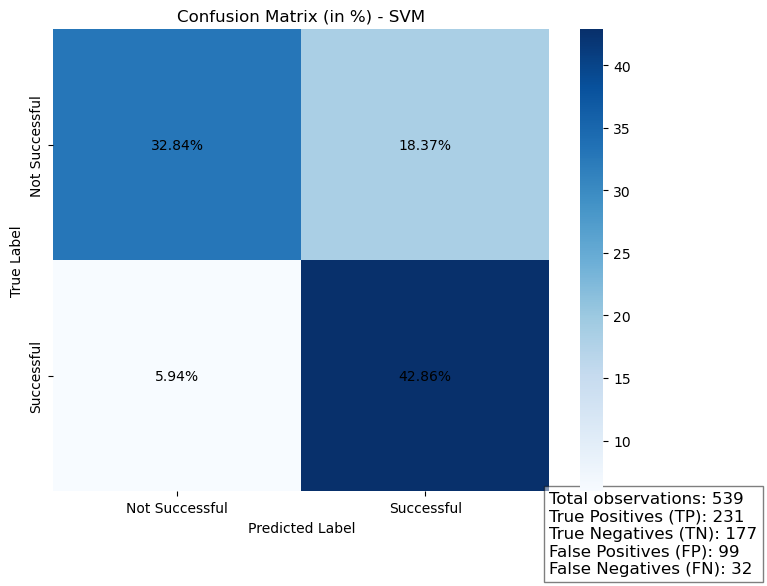

In [7]:
# Confusion Matrix with manual annotations
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm_optimal)
total_observations = np.sum(conf_matrix_svm)
conf_matrix_svm_percent = conf_matrix_svm / total_observations * 100

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm_percent, annot=False, fmt=".2f", cmap="Blues", cbar=True, xticklabels=['Not Successful', 'Successful'], yticklabels=['Not Successful', 'Successful'])

# Manually add the annotations in percentages
for i in range(conf_matrix_svm_percent.shape[0]):
    for j in range(conf_matrix_svm_percent.shape[1]):
        plt.text(j + 0.5, i + 0.5, f'{conf_matrix_svm_percent[i, j]:.2f}%', ha='center', va='center', color='black')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (in %) - SVM')

# Display total observations and individual counts
tp = conf_matrix_svm[1, 1]
tn = conf_matrix_svm[0, 0]
fp = conf_matrix_svm[0, 1]
fn = conf_matrix_svm[1, 0]

plt.text(2, 2, f'Total observations: {total_observations}\n'
               f'True Positives (TP): {tp}\n'
               f'True Negatives (TN): {tn}\n'
               f'False Positives (FP): {fp}\n'
               f'False Negatives (FN): {fn}', 
         fontsize=12, ha='left', va='top', color='black', 
         bbox=dict(facecolor='white', alpha=0.5))

plt.show()


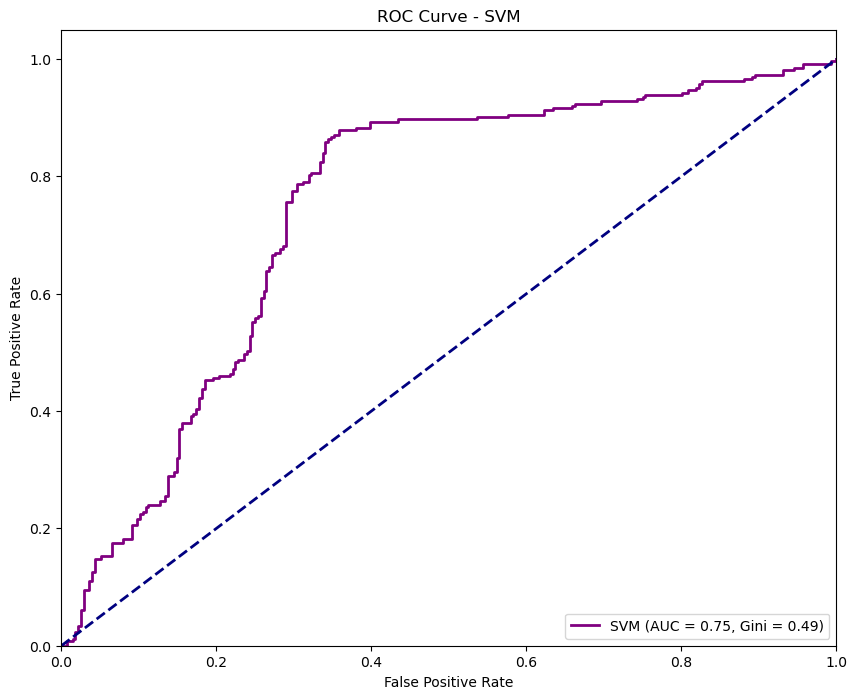

In [8]:
# ROC Curve
plt.figure(figsize=(10, 8))
plt.plot(fpr_svm, tpr_svm, color='purple', lw=2, label=f'SVM (AUC = {roc_auc_svm:.2f}, Gini = {gini_svm:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM')
plt.legend(loc="lower right")
plt.show()


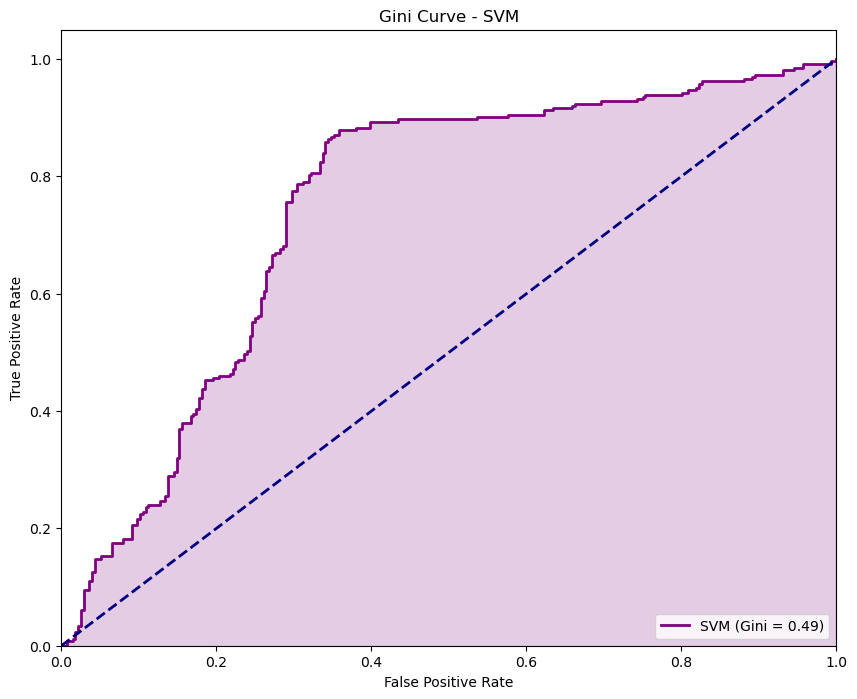

In [9]:
# Gini Curve
plt.figure(figsize=(10, 8))
plt.plot(fpr_svm, tpr_svm, color='purple', lw=2, label=f'SVM (Gini = {gini_svm:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.fill_between(fpr_svm, tpr_svm, alpha=0.2, color='purple')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gini Curve - SVM')
plt.legend(loc="lower right")
plt.show()


In [10]:
import joblib

# Assuming your SVM model is trained and stored in the variable `svm_model`
joblib.dump(svm_model, 'svm_model.pkl')


['svm_model.pkl']